## Models

In [ ]:
# TPU
# import tensorflow as tf
# import os

# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
# tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# tf.tpu.experimental.initialize_tpu_system(resolver)
# print("All devices: ", tf.config.list_logical_devices('TPU'))

In [ ]:
# !wget -c -O images.zip 'https://www.dropbox.com/scl/fi/2w1y67p7turdo3w1vfh8p/images.zip?rlkey=bpfxk4jp3e56zca2iulspz627&dl=0'

In [ ]:
# !zip -FF /notebooks/images.zip -O /notebooks/images_fixed.zip
# !unzip /notebooks/images_fixed.zip

In [ ]:
# !wget -c -O trained_model.zip https://www.dropbox.com/scl/fi/2tu163f2uycs041dikkvn/trained_model.zip?rlkey=af9iv94rygis2nm9m92q60dk2&dl=0
# !unzip /notebooks/trained_model.zip

### Import Required Libraries

In [1]:
import matplotlib.pyplot as plotter_lib
import pandas as pd
import numpy as np
import PIL as image_lib
import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

### Partition and Visualize Data

In [2]:
df = pd.read_csv('../data/df.csv', sep = '\t')

df['combined'] = df['gender'] + "_" + df['subCategory'] + "_" + df['articleType'] + "_" + \
                 df['baseColour'] + "_" + df['season'] + "_" + df['usage']

df

,id,gender,subCategory,articleType,baseColour,season,usage,image_path,gender_enc,subCategory_enc,articleType_enc,baseColour_enc,season_enc,usage_enc,combined
0,15970,Men,Topwear,Shirts,Navy Blue,Fall/Winter,Casual,../data/images/15970.jpg,2,1,6,10,0,0,Men_Topwear_Shirts_Navy Blue_Fall/Winter_Casual
1,39386,Men,Bottomwear,Jeans,Blue,Spring/Summer,Casual,../data/images/39386.jpg,2,0,2,2,1,0,Men_Bottomwear_Jeans_Blue_Spring/Summer_Casual
2,21379,Men,Bottomwear,Track Pants,Black,Fall/Winter,Casual,../data/images/21379.jpg,2,0,12,1,0,0,Men_Bottomwear_Track Pants_Black_Fall/Winter_C...
3,53759,Men,Topwear,Tshirts,Grey,Spring/Summer,Casual,../data/images/53759.jpg,2,1,14,7,1,0,Men_Topwear_Tshirts_Grey_Spring/Summer_Casual
4,1855,Men,Topwear,Tshirts,Grey,Spring/Summer,Casual,../data/images/1855.jpg,2,1,14,7,1,0,Men_Topwear_Tshirts_Grey_Spring/Summer_Casual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54338,13671,Unisex,Bottomwear,Jeans,Blue,Fall/Winter,Casual,../data/images/13671.jpg,3,0,2,2,0,0,Unisex_Bottomwear_Jeans_Blue_Fall/Winter_Casual
54339,33279,Unisex,Bottomwear,Jeans,Blue,Spring/Summer,Casual,../data/images/33279.jpg,3,0,2,2,1,0,Unisex_Bottomwear_Jeans_Blue_Spring/Summer_Casual
54340,13672,Unisex,Bottomwear,Jeans,Blue,Fall/Winter,Casual,../data/images/13672.jpg,3,0,2,2,0,0,Unisex_Bottomwear_Jeans_Blue_Fall/Winter_Casual
54341,33280,Unisex,Bottomwear,Jeans,Blue,Spring/Summer,Casual,../data/images/33280.jpg,3,0,2,2,1,0,Unisex_Bottomwear_Jeans_Blue_Spring/Summer_Casual


In [3]:
from sklearn.model_selection import train_test_split


df['combined'] = df['gender'] + "_" + df['subCategory'] + "_" + df['articleType'] + "_" + df['baseColour'] + "_" + \
                 df['season'] + "_" + df['usage']

In [ ]:
# import pathlib


# # Define a custom function to concatenate the strings
# def create_image_path(row):
#     path = '/notebooks/images/'
#     suffix = '.jpg'
#     return path + str(row['id']) + suffix


# df['image_path'] = df.apply(create_image_path, axis=1)

# # Display the resulting DataFrame with the new 'image_path' column
# df

In [4]:
from sklearn.model_selection import train_test_split


# Calculate the value counts of the 'combined' column
combined_value_counts = df['combined'].value_counts()

# Find the combined values with a count of 1
combined_values_with_1_count = combined_value_counts[combined_value_counts == 1].index

# Remove rows with these combined values from the DataFrame
df_filtered = df[~df['combined'].isin(combined_values_with_1_count)]

# Split the filtered DataFrame into train and test sets while stratifying by 'combined'
train, test = train_test_split(df_filtered, test_size=0.2, random_state=123, stratify=df_filtered[['combined']])

# Append the rows with 1 count back to the train set
train = pd.concat([train, df[df['combined'].isin(combined_values_with_1_count)]])

# Verify the sizes of train and test sets
print("Original size:", len(df))
print("Train + Test size:", len(train), '+', len(test), '=', len(train) + len(test))

Original size: 54343
Train + Test size: 43481 + 10862 = 54343


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define image dimensions
img_height, img_width = 224, 224

# Define batch size
batch_size = 32

y_col = ["subCategory_enc", "articleType_enc", "gender_enc", "baseColour_enc", "season_enc", "usage_enc"]

# Create a custom data generator for training data
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to the range [0, 1]
#     validation_split=0.2  # Specify validation split
)

# Use the flow_from_dataframe method to load and preprocess training images from the DataFrame
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    x_col="image_path",  # Column name in the DataFrame that contains image paths
    y_col=y_col,  # List of columns containing labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
#     subset="training",  # Specify training subset
    class_mode="multi_output",  # Use "multi_output" mode for multiple labels
    shuffle=True,  # Shuffle the data
    seed=123  # Random seed for reproducibility
)

# Use the flow_from_dataframe method to load and preprocess validation images from the DataFrame
validation_generator = datagen.flow_from_dataframe(
    dataframe=test, 
    x_col="image_path",  # Column name in the DataFrame that contains image paths
    y_col=y_col,  # List of columns containing labels
    target_size=(img_height, img_width),
    batch_size=batch_size,
#     subset="validation",  # Specify validation subset
    class_mode="multi_output",  # Use "multi_output" mode for multiple labels
    shuffle=False,  # No need to shuffle the validation data
    seed=123  # Random seed for reproducibility
)

# You can use the generated data for training and validation
# For example, you can fit a model using model.fit(train_generator, validation_data=validation_generator)

Found 43475 validated image filenames.


C:\Users\Lefteris_Souflas\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 6 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 10860 validated image filenames.


C:\Users\Lefteris_Souflas\anaconda3\lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


### Load, Train and Save Model

In [ ]:
# import tensorflow as tf
# tf.config.list_logical_devices('GPU')

In [6]:
import tensorflow as tf
devices = tf.config.experimental.list_physical_devices()
for device in devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [7]:
from tensorflow.keras.models import load_model


# tf.debugging.set_log_device_placement(True)
# gpus = tf.config.list_logical_devices('GPU')
# strategy = tf.distribute.MirroredStrategy(gpus)

# with strategy.scope():
# with tf.device('GPU'):
# model = load_model("../models/saved_models/trained_model", compile=False)
model = load_model("../models/saved_models/from_papersource/saved_models/notebooks/saved_models/trained_model.h5", 
                   compile=False)

# Compile the model with appropriate loss functions for each output
model.compile(optimizer='adam',
              loss={'subCategory_output': 'binary_crossentropy',
                    'articleType_output': 'sparse_categorical_crossentropy',  
                    'gender_output': 'sparse_categorical_crossentropy',
                    'baseColour_output': 'sparse_categorical_crossentropy',
                    'season_output': 'binary_crossentropy',
                    'usage_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

In [ ]:
# import os

# # Define the directory path
# checkpoint_dir = "/notebooks/checkpoints/"
# model_dir = "/notebooks/saved_models/"

# # Create the directory if it doesn't exist
# os.makedirs(checkpoint_dir, exist_ok=True)
# os.makedirs(model_dir, exist_ok=True)

In [10]:
epochs=70
initial_epoch=45
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            restore_best_weights=True)

checkpoint_filepath = 'checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [11]:
history = model.fit(train_generator, validation_data=validation_generator, epochs=epochs, initial_epoch=initial_epoch,
                    callbacks=[early_stopping_callback, model_checkpoint_callback])

Epoch 38/45
1359/1359 [==============================] - 3219s 2s/step - loss: 2.0965 - subCategory_output_loss: 0.0139 - articleType_output_loss: 0.3420 - gender_output_loss: 0.1322 - baseColour_output_loss: 1.0370 - season_output_loss: 0.3597 - usage_output_loss: 0.2118 - subCategory_output_accuracy: 0.9956 - articleType_output_accuracy: 0.8871 - gender_output_accuracy: 0.9528 - baseColour_output_accuracy: 0.6748 - season_output_accuracy: 0.8381 - usage_output_accuracy: 0.9297 - val_loss: 2.2541 - val_subCategory_output_loss: 0.0121 - val_articleType_output_loss: 0.3513 - val_gender_output_loss: 0.1283 - val_baseColour_output_loss: 1.1286 - val_season_output_loss: 0.4121 - val_usage_output_loss: 0.2217 - val_subCategory_output_accuracy: 0.9967 - val_articleType_output_accuracy: 0.8868 - val_gender_output_accuracy: 0.9570 - val_baseColour_output_accuracy: 0.6458 - val_season_output_accuracy: 0.8066 - val_usage_output_accuracy: 0.9266
Epoch 39/45
1359/1359 [============================

In [12]:
# Export model
model.save('saved_models/trained_model.h5', overwrite=True, save_format='h5')
model.save('saved_models/trained_model', overwrite=True, save_format='tf')
# # The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

C:\Users\Lefteris_Souflas\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: saved_models/trained_model\assets


INFO:tensorflow:Assets written to: saved_models/trained_model\assets


In [ ]:
# !zip -r /notebooks/saved_models.zip '/notebooks/checkpoints' '/notebooks/saved_models'

### Evaluate Model

In [13]:
# Combine the lists into a 2D array
accuracy_matrix = np.array([history.history['subCategory_output_accuracy'], 
                            history.history['articleType_output_accuracy'], 
                            history.history['gender_output_accuracy'], 
                            history.history['baseColour_output_accuracy'], 
                            history.history['season_output_accuracy'], 
                            history.history['usage_output_accuracy']])

# Calculate the average for each position (across all lists)
accuracy = np.mean(accuracy_matrix, axis=0)

In [14]:
# Combine the lists into a 2D array
val_accuracy_matrix = np.array([history.history['val_subCategory_output_accuracy'], 
                            history.history['val_articleType_output_accuracy'], 
                            history.history['val_gender_output_accuracy'], 
                            history.history['val_baseColour_output_accuracy'], 
                            history.history['val_season_output_accuracy'], 
                            history.history['val_usage_output_accuracy']])

# Calculate the average for each position (across all lists)
val_accuracy = np.mean(val_accuracy_matrix, axis=0)

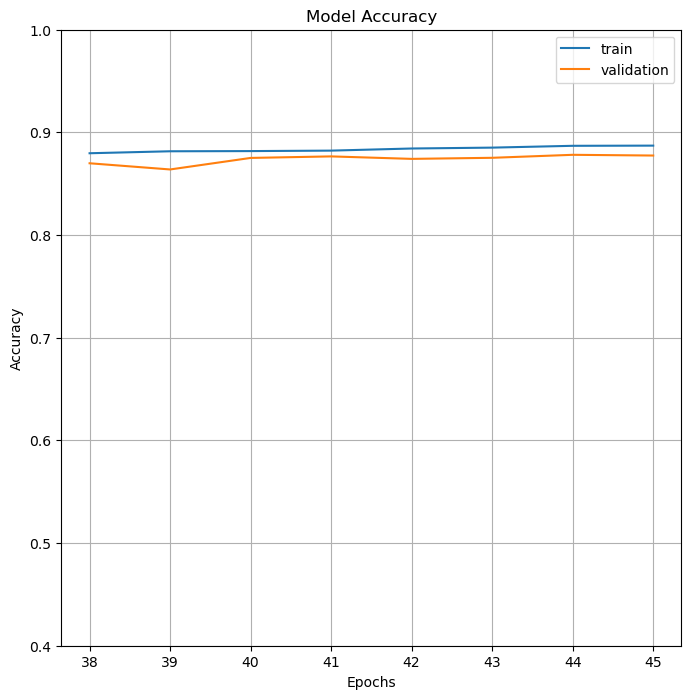

In [15]:
# Make sure both epochs_range and accuracy have the same length
plotter_lib.figure(figsize=(8, 8))
epochs_range = range(initial_epoch+1, epochs+1)
# epochs_range= range(epochs)

plotter_lib.plot(epochs_range, accuracy, label="Training Accuracy")
plotter_lib.plot(epochs_range, val_accuracy, label="Validation Accuracy")
plotter_lib.axis(ymin=0.4, ymax=1)
plotter_lib.grid()
plotter_lib.title('Model Accuracy')
plotter_lib.ylabel('Accuracy')
plotter_lib.xlabel('Epochs')
plotter_lib.legend(['train', 'validation'])

# plotter_lib.show()
# plotter_lib.savefig('output-plot_accuracy.png') 

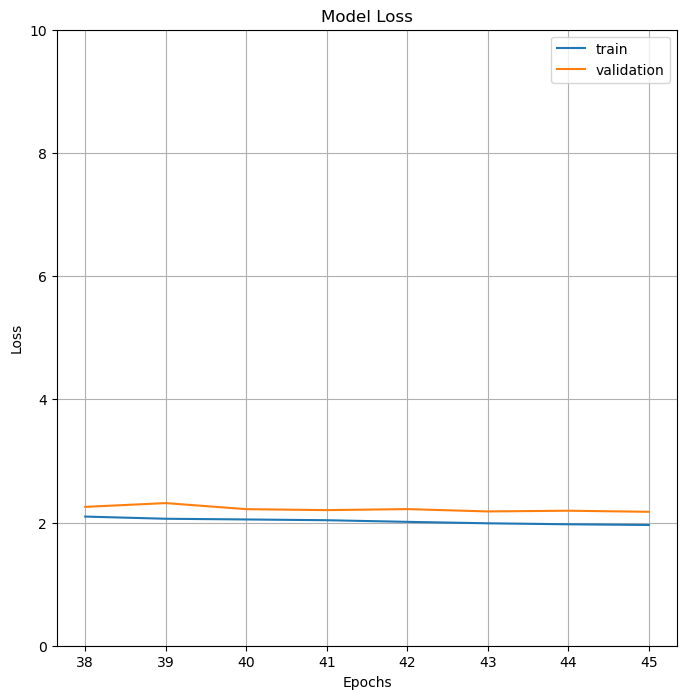

In [16]:
import matplotlib.pyplot as plt

# Assuming you have a history object from model.fit()

# Create a range of epochs
epochs_range = range(initial_epoch+1, epochs+1)

# Plotting
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history['loss'], label="Training Loss")
plt.plot(epochs_range, history.history['val_loss'], label="Validation Loss")
plt.axis(ymin=0, ymax=10)  # Adjust the y-axis range as needed
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()
